In [58]:
import pandas as pd
import numpy as np
import dill
import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import random
import copy
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from collections import defaultdict, Counter
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.optimizer import required
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.utils import class_weight
sns.set_theme(style="whitegrid")

In [2]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"

In [3]:
def createDictFloor(floor_idx,path):
    floorname = f'Floor{floor_idx}'
    fulldata = os.listdir(path)
    getdict = {}
    floors = [floor for floor in fulldata if floorname in floor]
    for name in floors:
        floor_zone = name.split(".")[0]
        getdict[floor_zone] = pd.read_csv(path+name, index_col=0, parse_dates=["Date"])
        getdict[floor_zone] = getdict[floor_zone].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def createDTFeat(date1, date2, datadict, featureX, featureY, resample_method_X="mean", resample_method_Y = "sum" ,scale=True):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for floorname in datadict.keys():
        dataX = datadict[floorname][date1:date2][featureX].copy()
        dataY = datadict[floorname][date1:date2][featureY].copy()
        
        if resample_method_X == "sum":
            dataX = dataX.resample("5T").sum()
            
        elif resample_method_X == "mean":
            dataX = dataX.resample("5T").mean().bfill()
        else:
            pass
        
        if resample_method_Y =="sum":
            dataY = dataY.resample("5T").sum()
        elif resample_method_Y == "mean":
            dataY = dataY.resample("5T").mean().bfill()
        else:
            pass
        
        resample_move[floorname] = pd.concat([dataX, dataY],axis=1)
        resample_move[floorname]["date"] = resample_move[floorname].index.date
        resample_move[floorname]["date"] = resample_move[floorname]["date"].apply(lambda x: x.strftime("%Y-%m-%d"))
    for date in resample_move[floors[0]]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
            
    return resample_move, dates

           
def data_scaling(datadict, feature):
    scalers = {}
    scaled_data_dict = datadict.copy()
    for floorname in datadict.keys():
        cols = datadict[floorname][feature].columns
        idx = datadict[floorname][feature].index
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(datadict[floorname][feature])
        scaled_data_dict[floorname][feature] = pd.DataFrame(scaler.transform(
                                                datadict[floorname][feature]),columns=cols,index=idx)
        scalers[data] = scaler

    return scaled_data_dict

def getInfoTimeShape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [4]:
def create_power_class(data_dict, conditions, feature):
    keys = sorted(list(data_dict.keys()))
    classes = list(conditions[keys[0]].keys())
    new_datadict = data_dict.copy()
    for floor_name in keys:
        data_dict[floor_name]["ACPowerClass"] = pd.Series(dtype='object')
        for p_class in classes:
            idx_classes = data_dict[floor_name].loc[(data_dict[floor_name][feature] >= conditions[floor_name][p_class][0]) &
                                         (data_dict[floor_name][feature] <= conditions[floor_name][p_class][1])]
            new_datadict[floor_name]["ACPowerClass"].loc[idx_classes.index] = new_datadict[floor_name]["ACPowerClass"].loc[idx_classes.index].apply(lambda x: p_class)
    return new_datadict

In [5]:
date1 = "2019-03-07"
date2 = "2019-12-31"
floor = 7
floor_dict = createDictFloor(floor, bkdatafolder)
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")

Floor7Z4 Start: 2019-03-06 14:46:00 End: 2019-12-31 23:59:00 Count:416243

Floor7Z5 Start: 2019-03-06 14:55:00 End: 2019-12-31 23:59:00 Count:407698

Floor7Z2 Start: 2019-03-06 14:48:00 End: 2019-12-31 23:59:00 Count:424701

Floor7Z1 Start: 2019-03-06 14:50:00 End: 2019-12-31 23:59:00 Count:424099



Floor7Z1
Floor7Z2
Floor7Z4
Floor7Z5


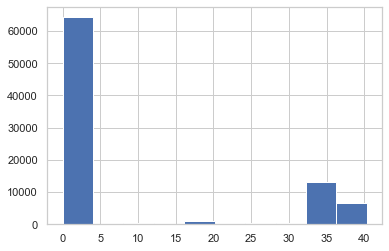

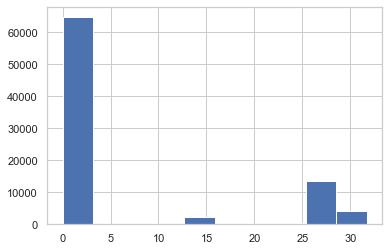

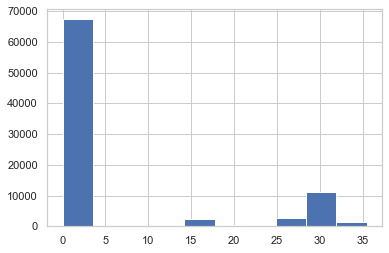

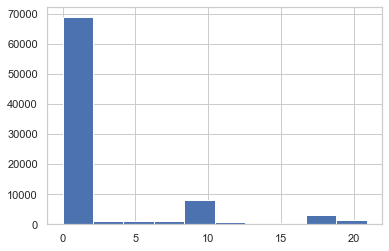

In [424]:
for floor in sorted(resample_data.keys()):
    plt.figure()
    print(floor)
    plt.hist(resample_data[floor]["ACPower"])

In [6]:
set_point = {"Floor7Z1":{"Low Power":[0,30],
                        "High Power":[30,100]},
            "Floor7Z2":{"Low Power":[0,25],
                       "High Power":[25,100]},
            "Floor7Z4":{"Low Power":[0,25],
                       "High Power":[25,100]},
            "Floor7Z5":{"Low Power":[0,15],
                       "High Power":[15,100]}}

In [256]:
def rolling_window(series, window_size, stride=1):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1, stride)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            databyDate[date][floor] = np.asarray(datadict[floor][date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def LoaderByZoneXY(dataX, dataY, zone_name,dates, seq_len, batch_size, shuffle=False):
    loaderZ = {}
    encode = {"Low Power": 0, "High Power": 1}
    #mid, high, low = 0., 0., 0.
    for i,date in enumerate(dates):
        trainx = rolling_window(dataX[date][zone_name], seq_len)
        trainy = rolling_window(dataY[date][zone_name], seq_len)
        print(len(trainy))
        to_class_y = torch.zeros((trainy.shape[0])) #[0.]*trainy.shape[0]
        mid, high, low = 0., 0., 0.
        for idx_y in range(trainy.shape[0]):
            selected = select_impact_powerclass(trainy[idx_y])
            if selected == "High Power":
                high += 1
            #elif selected == "Mid Power":
            #    mid += 1
            elif selected == "Low Power":
                low += 1
            to_class_y[idx_y] = encode[selected]
            #print(f'Chosen class {selected} Encode {to_class_y[idx_y]}')
        #print(f'Low count {low} High count {high}')
        xshape = torch.tensor(trainx, dtype=torch.float)
        yshape = torch.tensor(to_class_y, dtype=torch.long)
        print(xshape.shape, yshape.shape)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=False)
        loaderZ[date] = loaderxy
    return loaderZ

def select_impact_powerclass(y):
    rev_dict = defaultdict(list)
    ct = Counter(y)
    for k,v in ct.items():
        rev_dict[v].append(k)
    list_class = list(rev_dict.keys())
    if len(list_class) == 1:
        key = list_class[0]
        return rev_dict[key][0] 
    else:
        key = max(list_class)
        if len(rev_dict[key]) == 1:
            return rev_dict[key][0]
        elif len(rev_dict[key]) > 1:
            #if "Mid Power" in rev_dict[key]:
            #    return "Mid Power"
            if "High Power" in rev_dict[key]:
                return "High Power"
            else:
                return "Low Power"

In [102]:
featureX = ["temperature"]
featureY = "ACPower"
resample_methodX = "mean"
resample_methodY = "mean"
resample_data, remain_date = createDTFeat(date1, date2, floor_dict, featureX, featureY,resample_method_X=resample_methodX, resample_method_Y=resample_methodY)
resample_data_classes = create_power_class(resample_data, set_point, "ACPower")
scaled_data = data_scaling(resample_data_classes, featureX)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [103]:
cutting_date = "2019-05-08"
train_date, test_date = splitDate(remain_date, cutting_date)
databyDateX = createDataByDate(scaled_data, featureX, remain_date)
databyDateY = createDataByDate(scaled_data, "ACPowerClass", remain_date)

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_7813/1321597539.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [257]:
batch_size = 32
seq_len = 13
nb_zone = 5
trainloader = []
testloader = []
for zone in range(1,nb_zone+1):
    if zone != 3:
        zoneID = f"Floor{floor}Z{zone}"
        print(f'-----{zoneID}-----')
        loaderZtrain = LoaderByZoneXY(databyDateX, databyDateY, zoneID, train_date,seq_len,batch_size, shuffle=True)
        loaderZtest = LoaderByZoneXY(databyDateX, databyDateY, zoneID, test_date,seq_len,batch_size, shuffle=False)
        trainloader.append(loaderZtrain)
        testloader.append(loaderZtest)
zone_no=len(trainloader)

-----Floor7Z1-----
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_7813/565422866.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yshape = torch.tensor(to_class_y, dtype=torch.long)


 torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([

276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Siz

torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([2

276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Size([276, 13, 1]) torch.Size([276])
276
torch.Siz

In [79]:
nb_iterations = len(train_date)*len(trainloader[0]["2019-03-08"])
nb_iterations

567

# Algorithm 

In [21]:
import sys
sys.path.append('../src/')

In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

In [23]:
from algoaux import *
from optimizerDMFW import *
#from trainer import *
from graphs import *

In [16]:
class CNN1D(nn.Module):
    def __init__(self,nb_chan_out, nb_classes, input_len,kernel_size):
        super(CNN1D, self).__init__()
        
        #self.output_chan = 
        #self.output_len = output_l
        self.input_len = input_len
        
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=nb_chan_out, kernel_size=kernel_size, stride=1, 
                                padding=int(np.floor(kernel_size/2)))
        
        
        self.maxpool = nn.MaxPool1d(3)
        self.batchnorm = nn.BatchNorm1d(nb_chan_out)
        self.fc1 = nn.Linear(nb_chan_out*int((input_len/3)),nb_classes, bias=True)
        #self.fc2 = nn.Linear(16, nb_classes, bias=True)
        
    def forward(self, x):
        inputs = x.permute(0,2,1)
        #print(inputs.shape)
        out = self.conv1d(inputs)
        out = self.batchnorm(out)
        #print(out.shape)
        out = self.maxpool(out)
        #print(out.shape)
        out = nn.LeakyReLU()(out)
        
        out = out.view(-1, out.shape[1]*out.shape[2])
        
        out = self.fc1(out)
        #out = nn.LeakyReLU()(out)
        #out = self.fc2(out)
        return out

In [92]:
class Trainer:
    def __init__(self, graph, loaders, model, model_param, loss,
                 num_iterations):
        self.graph = graph
        self.num_nodes = graph.number_of_nodes()
        self.model = model
        self.param = model_param
        self.A = torch.tensor(nx.adjacency_matrix(graph).toarray())
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations + 1, 4),
                                     dtype='float')

        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        #self.class_weights = weights
        #self.gaps = [0.]*self.num_nodes

    def reset(self):
        self.optimizers = [0.] * self.num_nodes
        self.models = [0.] * self.num_nodes
        self.losses = [0.] * self.num_nodes
        self.gaps = [0.] * self.num_nodes
        self.best_models = [0.]*self.num_nodes
        self.acc = [0.]*self.num_nodes
        self.f1 = [0.]*self.num_nodes
        #self.loss_function = [self.loss(weight = torch.tensor(weights["Floor7Z1"], dtype=torch.float)),
        #                     self.loss(weight = torch.tensor(weights["Floor7Z2"], dtype=torch.float)),
        #                     self.loss(weight = torch.tensor(weights["Floor7Z4"], dtype=torch.float)),
        #                     self.loss(weight = torch.tensor(weights['Floor7Z5'], dtype=torch.float))]

        self.obj_values = np.ndarray((self.num_iterations + 1, 7),
                                     dtype='float')
        
    def __nodeInit(self, data, label):
        nodewrap = TensorDataset(data, label)
        nodes = DataLoader(nodewrap, batch_size=data.size(0), shuffle=False)
        return nodes

    def weight_reset(self, layer):
        if isinstance(layer, nn.BatchNorm1d) or isinstance(layer, nn.Linear) or isinstance(layer,nn.Conv1d):
            layer.reset_parameters()
            
    def initModelWeight(self, model):
        for name,param in model.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param,0.)
            elif 'weight' in name:
                if not 'batch' in name:
                    nn.init.xavier_normal_(param)
                else:
                    nn.init.uniform_(param)

    def saveCheckPts(self, t, path):
        check_pts = {}
        for i in range(self.num_nodes):
            ckp_i = {
                "t": t,
                "weight": [param for param in self.models[i].parameters()],
                "optimizer_weight": self.optimizers[i].w_dict,
                "oracles": self.optimizers[i].G,
                "loss": self.losses[i]
            }  #,
            #"avg_loss": self.avg_loss[i]}
            check_pts[i] = ckp_i
        torch.save(check_pts, path + "checkpts_models" + "_" + str(t) + ".tar")
        
    def plotPrediction(self, true, pred,date,path_to_save):
        fig = plt.figure(figsize=(5,3))
        plt.suptitle("{}".format(date))
        plt.plot(true)
        plt.plot(pred)
        #plt.show()
        fig.savefig(os.path.join(path_to_save,date))
        plt.close()

    def train(self, optimizer, L, eta_coef, eta_exp, reg_coef, radius, path_figure_date):
        seed_everything()
        self.reset()

        days= list(self.dataloader[0].keys())

        for i in range(self.num_nodes):
            self.models[i] = self.model(*self.param)
            self.optimizers[i] = optimizer(self.models[i].parameters(),
                                           eta_coef=eta_coef,
                                           eta_exp=eta_exp,
                                           L=L,
                                           matrix_line=self.A[i],
                                           reg_coef=reg_coef,
                                           radius=radius)
            self.best_models[i] = copy.deepcopy(self.models[i])

        self.final_gap = [0.] * self.num_nodes
        
        t = 0
        
        for date in days:
            acc_node = [0.]*self.num_nodes
            f1_node = [0.]*self.num_nodes
            prec_node = [0.]*self.num_nodes
            rec_node = [0.]*self.num_nodes
            for i,loader in enumerate(self.dataloader):
                acc_node[i], f1_node[i], prec_node[i], rec_node[i], _ , _, _  = ModelPrediction(self.best_models[i], date, loader)
                #if len(truez)==0 or len(predz)==0 : continue
            acc = np.mean(acc_node)
            f1  = np.mean(f1_node)
            prec = np.mean(prec_node)
            rec = np.mean(rec_node)


            z1, z2, z4, z5  = self.dataloader

            for (couple1, couple2, couple4, couple5) in zip(z1[date],z2[date], z4[date], z5[date]):
                datazones = [self.__nodeInit(*couple1), 
                             self.__nodeInit(*couple2),
                             self.__nodeInit(*couple4),
                             self.__nodeInit(*couple5)]

                for i in range(self.num_nodes):
                    self.initModelWeight(self.models[i])
                    self.models[i].train()
                    def closure():
                        self.optimizers[i].zero_grad(set_to_none=True)
                        x, y = iter(datazones[i]).next()
                        output = self.models[i](x)
                        loss = self.loss(output,y)
                        loss.backward()

                    self.optimizers[i].initValue(closure)

                opt_index = np.random.randint(low=0,high=L, size=1)


                for l in range(L):
                    #print("--------------------------")

                    if l==opt_index:
                        for i in range(self.num_nodes):
                            self.best_models[i] = copy.deepcopy(self.models[i])


                    for i in range(self.num_nodes):
                        self.optimizers[i].neighborsAverage(self.optimizers)
                        
                    for i in range(self.num_nodes):
                        
                        def closure():
                            self.optimizers[i].zero_grad(set_to_none=True)
                            x, y = iter(datazones[i]).next()
                            output = self.models[i](x)
                            loss = self.loss(output, y)
                            loss.backward()
                            
                        self.optimizers[i].step(l, closure)

                self.gaps_off = [0.] * self.num_nodes
                for i in range(self.num_nodes):
                    total = 0.
                    correct = 0.
                    with torch.no_grad():
                        self.models[i].eval()
                        x, y = iter(datazones[i]).next()
                        outputs = self.best_models[i](x)
                        curr_loss = self.loss(outputs, y)
                        
                        _, predicted = torch.max(outputs,1)
                        total += y.size(0)
                        correct += (predicted == y).sum().item()
                        
                        true, pred = y.detach().numpy(), predicted.detach().numpy()
                    #self.acc[i] = correct/total
                    #self.f1[i] = f1_score(true, pred, average='weighted')
                    self.final_gap[i] += self.optimizers[i].init_gap
                    self.final_gap[i] /= (t + 1)
                    self.gaps_off[i] = self.optimizers[i].init_gap
                    self.losses[i] = curr_loss.detach().numpy()

                loss = np.mean(self.losses)
                #acc = np.mean(self.acc)
                #f1 = np.mean(self.f1)
                gap = np.max(self.final_gap)  #.detach().numpy(
                local_gap = np.max(self.gaps_off)
                if t % 1 == 0:
                    print("t_{} : loss : {:.5f} gap : {:.5f} acc {:.5f} f1 {:.5f} precision {:.5f} recall {:.5f}".format(
                        t, loss, gap, acc, f1, prec, rec))
                    #print(f't : {t} acc : {acc} f1 : {f1} prec : {prec} recall : {recall}')
                try:
                    self.obj_values[t, :] = [t, loss, gap, acc, f1, prec, rec]
                except:
                    print ("problem in Training Process... Skipping for debug...")
                    # import pdb; pdb.set_trace()
                    
                t+=1
        return self.obj_values

In [427]:
loss_fn = nn.CrossEntropyLoss()
num_iters_base = nb_iterations
eta_coef_DMFW = 1
eta_exp_DMFW = 0.75
rho_coef_DMFW = 4e-0
rho_exp_DMFW = 1/2
reg_coef_DMFW = 10
L_DMFW = 200#nb_iterations

In [479]:
nx.adjacency_matrix(complete).toarray()

array([[0.5       , 0.16666667, 0.16666667, 0.16666667],
       [0.16666667, 0.5       , 0.16666667, 0.16666667],
       [0.16666667, 0.16666667, 0.5       , 0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.5       ]])

In [446]:
complete ,_ = completegraph(4)
cycle, _ = cycle_graph(4)
grid, _ = gridgraph(2,2)
line, _ = gridgraph(4,1)

In [450]:
trainXMFW = Trainer(line,trainloader,CNN1D, (8,3,seq_len,3), loss_fn,num_iters_base)

In [451]:
values_dmfw = trainXMFW.train(DMFW, L_DMFW, eta_coef_DMFW, eta_exp_DMFW, reg_coef_DMFW,1,
                            path_figure_date=None)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforg

t_0 : loss : 1.09807 gap : 0.01991 acc 0.40308 f1 0.31316 precision 0.27915 recall 0.40308
t_1 : loss : 0.49928 gap : 0.01495 acc 0.40308 f1 0.31316 precision 0.27915 recall 0.40308
t_2 : loss : 0.66741 gap : 0.00610 acc 0.40308 f1 0.31316 precision 0.27915 recall 0.40308
t_3 : loss : 0.53712 gap : 0.00497 acc 0.40308 f1 0.31316 precision 0.27915 recall 0.40308
t_4 : loss : 0.79981 gap : 0.00190 acc 0.40308 f1 0.31316 precision 0.27915 recall 0.40308
t_5 : loss : 0.57571 gap : 0.00370 acc 0.40308 f1 0.31316 precision 0.27915 recall 0.40308
t_6 : loss : 0.47759 gap : 0.00246 acc 0.40308 f1 0.31316 precision 0.27915 recall 0.40308
t_7 : loss : 0.30530 gap : 0.00166 acc 0.40308 f1 0.31316 precision 0.27915 recall 0.40308
t_8 : loss : 0.41708 gap : 0.00274 acc 0.40308 f1 0.31316 precision 0.27915 recall 0.40308


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_9 : loss : 0.35369 gap : 0.00094 acc 0.84239 f1 0.80088 precision 0.79951 recall 0.84239
t_10 : loss : 0.39298 gap : 0.00101 acc 0.84239 f1 0.80088 precision 0.79951 recall 0.84239
t_11 : loss : 0.32409 gap : 0.00096 acc 0.84239 f1 0.80088 precision 0.79951 recall 0.84239
t_12 : loss : 0.32966 gap : 0.00064 acc 0.84239 f1 0.80088 precision 0.79951 recall 0.84239
t_13 : loss : 0.40476 gap : 0.00068 acc 0.84239 f1 0.80088 precision 0.79951 recall 0.84239
t_14 : loss : 0.28536 gap : 0.00059 acc 0.84239 f1 0.80088 precision 0.79951 recall 0.84239
t_15 : loss : 0.38753 gap : 0.00050 acc 0.84239 f1 0.80088 precision 0.79951 recall 0.84239
t_16 : loss : 0.37703 gap : 0.00054 acc 0.84239 f1 0.80088 precision 0.79951 recall 0.84239
t_17 : loss : 0.27167 gap : 0.00045 acc 0.84239 f1 0.80088 precision 0.79951 recall 0.84239
t_18 : loss : 0.25046 gap : 0.00029 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_19 : loss : 0.09726 gap : 0.00012 acc 1.00000 f1 1.00000 precision 1.00000 reca

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforg

t_36 : loss : 0.73963 gap : 0.00096 acc 0.74185 f1 0.63734 precision 0.56579 recall 0.74185
t_37 : loss : 0.58699 gap : 0.00054 acc 0.74185 f1 0.63734 precision 0.56579 recall 0.74185
t_38 : loss : 0.48909 gap : 0.00025 acc 0.74185 f1 0.63734 precision 0.56579 recall 0.74185
t_39 : loss : 0.30864 gap : 0.00027 acc 0.74185 f1 0.63734 precision 0.56579 recall 0.74185
t_40 : loss : 0.37900 gap : 0.00021 acc 0.74185 f1 0.63734 precision 0.56579 recall 0.74185
t_41 : loss : 0.35239 gap : 0.00020 acc 0.74185 f1 0.63734 precision 0.56579 recall 0.74185
t_42 : loss : 0.43171 gap : 0.00015 acc 0.74185 f1 0.63734 precision 0.56579 recall 0.74185
t_43 : loss : 0.36111 gap : 0.00018 acc 0.74185 f1 0.63734 precision 0.56579 recall 0.74185
t_44 : loss : 0.38159 gap : 0.00014 acc 0.74185 f1 0.63734 precision 0.56579 recall 0.74185


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_45 : loss : 0.31536 gap : 0.00019 acc 0.88859 f1 0.92023 precision 0.96670 recall 0.88859
t_46 : loss : 0.30695 gap : 0.00023 acc 0.88859 f1 0.92023 precision 0.96670 recall 0.88859
t_47 : loss : 0.32580 gap : 0.00019 acc 0.88859 f1 0.92023 precision 0.96670 recall 0.88859
t_48 : loss : 0.28847 gap : 0.00018 acc 0.88859 f1 0.92023 precision 0.96670 recall 0.88859
t_49 : loss : 0.31586 gap : 0.00020 acc 0.88859 f1 0.92023 precision 0.96670 recall 0.88859
t_50 : loss : 0.29921 gap : 0.00018 acc 0.88859 f1 0.92023 precision 0.96670 recall 0.88859
t_51 : loss : 0.35559 gap : 0.00018 acc 0.88859 f1 0.92023 precision 0.96670 recall 0.88859
t_52 : loss : 0.31825 gap : 0.00016 acc 0.88859 f1 0.92023 precision 0.96670 recall 0.88859
t_53 : loss : 0.33271 gap : 0.00015 acc 0.88859 f1 0.92023 precision 0.96670 recall 0.88859
t_54 : loss : 0.32934 gap : 0.00015 acc 0.91757 f1 0.93118 precision 0.96207 recall 0.91757
t_55 : loss : 0.25040 gap : 0.00015 acc 0.91757 f1 0.93118 precision 0.96207 rec

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_63 : loss : 0.29224 gap : 0.00012 acc 0.85870 f1 0.89808 precision 0.96254 recall 0.85870
t_64 : loss : 0.29897 gap : 0.00017 acc 0.85870 f1 0.89808 precision 0.96254 recall 0.85870
t_65 : loss : 0.31571 gap : 0.00017 acc 0.85870 f1 0.89808 precision 0.96254 recall 0.85870
t_66 : loss : 0.29687 gap : 0.00014 acc 0.85870 f1 0.89808 precision 0.96254 recall 0.85870
t_67 : loss : 0.71476 gap : 0.00014 acc 0.85870 f1 0.89808 precision 0.96254 recall 0.85870
t_68 : loss : 0.28678 gap : 0.00011 acc 0.85870 f1 0.89808 precision 0.96254 recall 0.85870
t_69 : loss : 0.27541 gap : 0.00011 acc 0.85870 f1 0.89808 precision 0.96254 recall 0.85870
t_70 : loss : 0.28148 gap : 0.00011 acc 0.85870 f1 0.89808 precision 0.96254 recall 0.85870
t_71 : loss : 0.30101 gap : 0.00012 acc 0.85870 f1 0.89808 precision 0.96254 recall 0.85870


/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_72 : loss : 0.26022 gap : 0.00010 acc 0.86775 f1 0.84185 precision 0.83534 recall 0.86775
t_73 : loss : 0.31652 gap : 0.00016 acc 0.86775 f1 0.84185 precision 0.83534 recall 0.86775
t_74 : loss : 0.29768 gap : 0.00010 acc 0.86775 f1 0.84185 precision 0.83534 recall 0.86775
t_75 : loss : 0.30717 gap : 0.00013 acc 0.86775 f1 0.84185 precision 0.83534 recall 0.86775
t_76 : loss : 0.31677 gap : 0.00011 acc 0.86775 f1 0.84185 precision 0.83534 recall 0.86775
t_77 : loss : 0.30929 gap : 0.00014 acc 0.86775 f1 0.84185 precision 0.83534 recall 0.86775
t_78 : loss : 0.29151 gap : 0.00011 acc 0.86775 f1 0.84185 precision 0.83534 recall 0.86775
t_79 : loss : 0.28258 gap : 0.00009 acc 0.86775 f1 0.84185 precision 0.83534 recall 0.86775
t_80 : loss : 0.23461 gap : 0.00010 acc 0.86775 f1 0.84185 precision 0.83534 recall 0.86775
t_81 : loss : 0.06803 gap : 0.00002 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_82 : loss : 0.03715 gap : 0.00001 acc 1.00000 f1 1.00000 precision 1.00000 rec

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforg

t_99 : loss : 0.75370 gap : 0.00039 acc 0.75815 f1 0.65967 precision 0.59166 recall 0.75815
t_100 : loss : 0.29682 gap : 0.00010 acc 0.75815 f1 0.65967 precision 0.59166 recall 0.75815
t_101 : loss : 0.37759 gap : 0.00014 acc 0.75815 f1 0.65967 precision 0.59166 recall 0.75815
t_102 : loss : 0.27773 gap : 0.00007 acc 0.75815 f1 0.65967 precision 0.59166 recall 0.75815
t_103 : loss : 0.38565 gap : 0.00016 acc 0.75815 f1 0.65967 precision 0.59166 recall 0.75815
t_104 : loss : 0.29592 gap : 0.00007 acc 0.75815 f1 0.65967 precision 0.59166 recall 0.75815
t_105 : loss : 0.36235 gap : 0.00010 acc 0.75815 f1 0.65967 precision 0.59166 recall 0.75815
t_106 : loss : 0.32114 gap : 0.00007 acc 0.75815 f1 0.65967 precision 0.59166 recall 0.75815
t_107 : loss : 0.33898 gap : 0.00007 acc 0.75815 f1 0.65967 precision 0.59166 recall 0.75815
t_108 : loss : 0.35958 gap : 0.00008 acc 0.89583 f1 0.91590 precision 0.94984 recall 0.89583
t_109 : loss : 0.25539 gap : 0.00006 acc 0.89583 f1 0.91590 precision 0

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforg

t_162 : loss : 0.54740 gap : 0.00030 acc 0.71467 f1 0.59889 precision 0.51914 recall 0.71467
t_163 : loss : 0.41149 gap : 0.00005 acc 0.71467 f1 0.59889 precision 0.51914 recall 0.71467
t_164 : loss : 0.45082 gap : 0.00007 acc 0.71467 f1 0.59889 precision 0.51914 recall 0.71467
t_165 : loss : 0.50365 gap : 0.00009 acc 0.71467 f1 0.59889 precision 0.51914 recall 0.71467
t_166 : loss : 0.42939 gap : 0.00006 acc 0.71467 f1 0.59889 precision 0.51914 recall 0.71467
t_167 : loss : 0.31633 gap : 0.00005 acc 0.71467 f1 0.59889 precision 0.51914 recall 0.71467
t_168 : loss : 0.40349 gap : 0.00006 acc 0.71467 f1 0.59889 precision 0.51914 recall 0.71467
t_169 : loss : 0.43898 gap : 0.00004 acc 0.71467 f1 0.59889 precision 0.51914 recall 0.71467
t_170 : loss : 0.31242 gap : 0.00002 acc 0.71467 f1 0.59889 precision 0.51914 recall 0.71467
t_171 : loss : 1.00618 gap : 0.00005 acc 0.91395 f1 0.93438 precision 0.96820 recall 0.91395
t_172 : loss : 0.64272 gap : 0.00007 acc 0.91395 f1 0.93438 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_180 : loss : 0.29821 gap : 0.00004 acc 0.80888 f1 0.74616 precision 0.76709 recall 0.80888
t_181 : loss : 0.25361 gap : 0.00003 acc 0.80888 f1 0.74616 precision 0.76709 recall 0.80888
t_182 : loss : 0.28387 gap : 0.00005 acc 0.80888 f1 0.74616 precision 0.76709 recall 0.80888
t_183 : loss : 0.30268 gap : 0.00004 acc 0.80888 f1 0.74616 precision 0.76709 recall 0.80888
t_184 : loss : 0.25426 gap : 0.00004 acc 0.80888 f1 0.74616 precision 0.76709 recall 0.80888
t_185 : loss : 0.31933 gap : 0.00004 acc 0.80888 f1 0.74616 precision 0.76709 recall 0.80888
t_186 : loss : 0.31440 gap : 0.00005 acc 0.80888 f1 0.74616 precision 0.76709 recall 0.80888
t_187 : loss : 0.36419 gap : 0.00004 acc 0.80888 f1 0.74616 precision 0.76709 recall 0.80888
t_188 : loss : 0.29061 gap : 0.00004 acc 0.80888 f1 0.74616 precision 0.76709 recall 0.80888
t_189 : loss : 0.50695 gap : 0.00004 acc 0.90489 f1 0.92972 precision 0.97120 recall 0.90489
t_190 : loss : 0.32704 gap : 0.00005 acc 0.90489 f1 0.92972 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_198 : loss : 0.32155 gap : 0.00004 acc 0.71649 f1 0.61159 precision 0.61543 recall 0.71649
t_199 : loss : 0.31321 gap : 0.00003 acc 0.71649 f1 0.61159 precision 0.61543 recall 0.71649
t_200 : loss : 0.34290 gap : 0.00005 acc 0.71649 f1 0.61159 precision 0.61543 recall 0.71649
t_201 : loss : 0.27986 gap : 0.00003 acc 0.71649 f1 0.61159 precision 0.61543 recall 0.71649
t_202 : loss : 0.27221 gap : 0.00004 acc 0.71649 f1 0.61159 precision 0.61543 recall 0.71649
t_203 : loss : 0.29648 gap : 0.00003 acc 0.71649 f1 0.61159 precision 0.61543 recall 0.71649
t_204 : loss : 0.35427 gap : 0.00003 acc 0.71649 f1 0.61159 precision 0.61543 recall 0.71649
t_205 : loss : 0.36469 gap : 0.00005 acc 0.71649 f1 0.61159 precision 0.61543 recall 0.71649
t_206 : loss : 0.32759 gap : 0.00005 acc 0.71649 f1 0.61159 precision 0.61543 recall 0.71649
t_207 : loss : 0.27724 gap : 0.00003 acc 1.00000 f1 1.00000 precision 1.00000 recall 1.00000
t_208 : loss : 0.24874 gap : 0.00003 acc 1.00000 f1 1.00000 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforg

t_225 : loss : 0.93003 gap : 0.00019 acc 0.62862 f1 0.48999 precision 0.40561 recall 0.62862
t_226 : loss : 0.55785 gap : 0.00006 acc 0.62862 f1 0.48999 precision 0.40561 recall 0.62862
t_227 : loss : 0.44722 gap : 0.00005 acc 0.62862 f1 0.48999 precision 0.40561 recall 0.62862
t_228 : loss : 0.54614 gap : 0.00008 acc 0.62862 f1 0.48999 precision 0.40561 recall 0.62862
t_229 : loss : 0.53756 gap : 0.00007 acc 0.62862 f1 0.48999 precision 0.40561 recall 0.62862
t_230 : loss : 0.35871 gap : 0.00002 acc 0.62862 f1 0.48999 precision 0.40561 recall 0.62862
t_231 : loss : 0.42905 gap : 0.00004 acc 0.62862 f1 0.48999 precision 0.40561 recall 0.62862
t_232 : loss : 0.40853 gap : 0.00006 acc 0.62862 f1 0.48999 precision 0.40561 recall 0.62862
t_233 : loss : 0.35561 gap : 0.00004 acc 0.62862 f1 0.48999 precision 0.40561 recall 0.62862
t_234 : loss : 0.59539 gap : 0.00003 acc 0.91395 f1 0.92568 precision 0.95456 recall 0.91395
t_235 : loss : 0.25159 gap : 0.00003 acc 0.91395 f1 0.92568 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_252 : loss : 0.35667 gap : 0.00003 acc 0.86504 f1 0.89238 precision 0.94521 recall 0.86504
t_253 : loss : 0.31768 gap : 0.00003 acc 0.86504 f1 0.89238 precision 0.94521 recall 0.86504
t_254 : loss : 0.32987 gap : 0.00004 acc 0.86504 f1 0.89238 precision 0.94521 recall 0.86504
t_255 : loss : 0.31685 gap : 0.00002 acc 0.86504 f1 0.89238 precision 0.94521 recall 0.86504
t_256 : loss : 0.35035 gap : 0.00004 acc 0.86504 f1 0.89238 precision 0.94521 recall 0.86504
t_257 : loss : 0.34001 gap : 0.00004 acc 0.86504 f1 0.89238 precision 0.94521 recall 0.86504
t_258 : loss : 0.29137 gap : 0.00004 acc 0.86504 f1 0.89238 precision 0.94521 recall 0.86504
t_259 : loss : 0.27550 gap : 0.00004 acc 0.86504 f1 0.89238 precision 0.94521 recall 0.86504
t_260 : loss : 0.28298 gap : 0.00004 acc 0.86504 f1 0.89238 precision 0.94521 recall 0.86504
t_261 : loss : 0.30291 gap : 0.00002 acc 0.88134 f1 0.88399 precision 0.92307 recall 0.88134
t_262 : loss : 0.27150 gap : 0.00001 acc 0.88134 f1 0.88399 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforg

t_297 : loss : 1.63426 gap : 0.00009 acc 0.60870 f1 0.46324 precision 0.37598 recall 0.60870
t_298 : loss : 0.70918 gap : 0.00005 acc 0.60870 f1 0.46324 precision 0.37598 recall 0.60870
t_299 : loss : 0.64538 gap : 0.00005 acc 0.60870 f1 0.46324 precision 0.37598 recall 0.60870
t_300 : loss : 0.40148 gap : 0.00003 acc 0.60870 f1 0.46324 precision 0.37598 recall 0.60870
t_301 : loss : 0.36674 gap : 0.00002 acc 0.60870 f1 0.46324 precision 0.37598 recall 0.60870
t_302 : loss : 0.39871 gap : 0.00003 acc 0.60870 f1 0.46324 precision 0.37598 recall 0.60870
t_303 : loss : 0.59428 gap : 0.00007 acc 0.60870 f1 0.46324 precision 0.37598 recall 0.60870
t_304 : loss : 0.49609 gap : 0.00004 acc 0.60870 f1 0.46324 precision 0.37598 recall 0.60870
t_305 : loss : 0.25928 gap : 0.00001 acc 0.60870 f1 0.46324 precision 0.37598 recall 0.60870
t_306 : loss : 0.29666 gap : 0.00004 acc 0.89764 f1 0.89985 precision 0.91244 recall 0.89764
t_307 : loss : 0.31582 gap : 0.00003 acc 0.89764 f1 0.89985 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_369 : loss : 1.07613 gap : 0.00007 acc 0.60326 f1 0.45835 precision 0.48439 recall 0.60326
t_370 : loss : 0.63284 gap : 0.00006 acc 0.60326 f1 0.45835 precision 0.48439 recall 0.60326
t_371 : loss : 0.63345 gap : 0.00006 acc 0.60326 f1 0.45835 precision 0.48439 recall 0.60326
t_372 : loss : 0.42428 gap : 0.00003 acc 0.60326 f1 0.45835 precision 0.48439 recall 0.60326
t_373 : loss : 0.54358 gap : 0.00005 acc 0.60326 f1 0.45835 precision 0.48439 recall 0.60326
t_374 : loss : 0.46868 gap : 0.00004 acc 0.60326 f1 0.45835 precision 0.48439 recall 0.60326
t_375 : loss : 0.40446 gap : 0.00003 acc 0.60326 f1 0.45835 precision 0.48439 recall 0.60326
t_376 : loss : 0.43249 gap : 0.00003 acc 0.60326 f1 0.45835 precision 0.48439 recall 0.60326
t_377 : loss : 0.42064 gap : 0.00003 acc 0.60326 f1 0.45835 precision 0.48439 recall 0.60326
t_378 : loss : 0.24004 gap : 0.00001 acc 0.79167 f1 0.75246 precision 0.85348 recall 0.79167
t_379 : loss : 0.46853 gap : 0.00001 acc 0.79167 f1 0.75246 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_414 : loss : 0.67156 gap : 0.00005 acc 0.82156 f1 0.78819 precision 0.77451 recall 0.82156
t_415 : loss : 0.72289 gap : 0.00008 acc 0.82156 f1 0.78819 precision 0.77451 recall 0.82156
t_416 : loss : 0.51426 gap : 0.00005 acc 0.82156 f1 0.78819 precision 0.77451 recall 0.82156
t_417 : loss : 0.35120 gap : 0.00003 acc 0.82156 f1 0.78819 precision 0.77451 recall 0.82156
t_418 : loss : 0.38880 gap : 0.00002 acc 0.82156 f1 0.78819 precision 0.77451 recall 0.82156
t_419 : loss : 0.36541 gap : 0.00001 acc 0.82156 f1 0.78819 precision 0.77451 recall 0.82156
t_420 : loss : 0.30429 gap : 0.00001 acc 0.82156 f1 0.78819 precision 0.77451 recall 0.82156
t_421 : loss : 0.35616 gap : 0.00002 acc 0.82156 f1 0.78819 precision 0.77451 recall 0.82156
t_422 : loss : 0.32166 gap : 0.00002 acc 0.82156 f1 0.78819 precision 0.77451 recall 0.82156
t_423 : loss : 0.21351 gap : 0.00001 acc 0.77989 f1 0.79358 precision 0.91095 recall 0.77989
t_424 : loss : 0.22582 gap : 0.00003 acc 0.77989 f1 0.79358 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforg

t_441 : loss : 0.80585 gap : 0.00003 acc 0.66214 f1 0.53402 precision 0.45297 recall 0.66214
t_442 : loss : 0.24887 gap : 0.00001 acc 0.66214 f1 0.53402 precision 0.45297 recall 0.66214
t_443 : loss : 0.29331 gap : 0.00001 acc 0.66214 f1 0.53402 precision 0.45297 recall 0.66214
t_444 : loss : 0.25410 gap : 0.00002 acc 0.66214 f1 0.53402 precision 0.45297 recall 0.66214
t_445 : loss : 0.23910 gap : 0.00001 acc 0.66214 f1 0.53402 precision 0.45297 recall 0.66214
t_446 : loss : 0.23686 gap : 0.00003 acc 0.66214 f1 0.53402 precision 0.45297 recall 0.66214
t_447 : loss : 0.25217 gap : 0.00001 acc 0.66214 f1 0.53402 precision 0.45297 recall 0.66214
t_448 : loss : 0.28662 gap : 0.00002 acc 0.66214 f1 0.53402 precision 0.45297 recall 0.66214
t_449 : loss : 0.27465 gap : 0.00001 acc 0.66214 f1 0.53402 precision 0.45297 recall 0.66214
t_450 : loss : 0.74110 gap : 0.00001 acc 0.91848 f1 0.92008 precision 0.92687 recall 0.91848
t_451 : loss : 0.23245 gap : 0.00001 acc 0.91848 f1 0.92008 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t_522 : loss : 0.23946 gap : 0.00002 acc 0.50906 f1 0.43510 precision 0.62867 recall 0.50906
t_523 : loss : 0.20626 gap : 0.00002 acc 0.50906 f1 0.43510 precision 0.62867 recall 0.50906
t_524 : loss : 0.20528 gap : 0.00001 acc 0.50906 f1 0.43510 precision 0.62867 recall 0.50906
t_525 : loss : 0.23299 gap : 0.00002 acc 0.50906 f1 0.43510 precision 0.62867 recall 0.50906
t_526 : loss : 0.19820 gap : 0.00001 acc 0.50906 f1 0.43510 precision 0.62867 recall 0.50906
t_527 : loss : 0.14315 gap : 0.00001 acc 0.50906 f1 0.43510 precision 0.62867 recall 0.50906
t_528 : loss : 0.21865 gap : 0.00001 acc 0.50906 f1 0.43510 precision 0.62867 recall 0.50906
t_529 : loss : 0.14474 gap : 0.00001 acc 0.50906 f1 0.43510 precision 0.62867 recall 0.50906
t_530 : loss : 0.20231 gap : 0.00002 acc 0.50906 f1 0.43510 precision 0.62867 recall 0.50906
t_531 : loss : 0.14839 gap : 0.00001 acc 0.94384 f1 0.93677 precision 0.95196 recall 0.94384
t_532 : loss : 0.14897 gap : 0.00001 acc 0.94384 f1 0.93677 precision 

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/

t_558 : loss : 0.18228 gap : 0.00001 acc 0.26178 f1 0.13649 precision 0.09266 recall 0.26178
t_559 : loss : 0.25561 gap : 0.00001 acc 0.26178 f1 0.13649 precision 0.09266 recall 0.26178
t_560 : loss : 0.25061 gap : 0.00001 acc 0.26178 f1 0.13649 precision 0.09266 recall 0.26178
t_561 : loss : 0.19812 gap : 0.00000 acc 0.26178 f1 0.13649 precision 0.09266 recall 0.26178
t_562 : loss : 0.18390 gap : 0.00001 acc 0.26178 f1 0.13649 precision 0.09266 recall 0.26178
t_563 : loss : 0.16486 gap : 0.00001 acc 0.26178 f1 0.13649 precision 0.09266 recall 0.26178
t_564 : loss : 0.19612 gap : 0.00001 acc 0.26178 f1 0.13649 precision 0.09266 recall 0.26178
t_565 : loss : 0.16047 gap : 0.00001 acc 0.26178 f1 0.13649 precision 0.09266 recall 0.26178
t_566 : loss : 0.15599 gap : 0.00001 acc 0.26178 f1 0.13649 precision 0.09266 recall 0.26178


In [453]:
path_log = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp-ac-classification/line/alpha075-200"
if not os.path.exists(path_log):
    os.makedirs(path_log)

In [454]:
def save_log_csv(log_file, path_to_save,floor_idx,graph):
    logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap", "Accuracy","F1","Precision","Recall"])
    pd.DataFrame.to_csv(logs, os.path.join(path_to_save,f'Floor_{floor_idx}_'+"_"+f'{graph}'+".csv"))
def save_state_dict(model, model_idx, path_to_save,floor_idx,graph):
    torch.save(model.state_dict(), os.path.join(path_to_save,f'Floor{floor_idx}_model{model_idx}_{graph}_statedict.pt'))

In [455]:
save_log_csv(values_dmfw, path_log, floor, "cycle")
for i in range(4):
    save_state_dict(trainXMFW.best_models[i],i, path_log, floor,"cycle")

In [456]:
values_dmfw.shape

(568, 7)

In [457]:
np.mean(values_dmfw[:,1][:-1])

0.2698714794883442

In [458]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

Text(0, 0.5, 'Accuracy/F1')

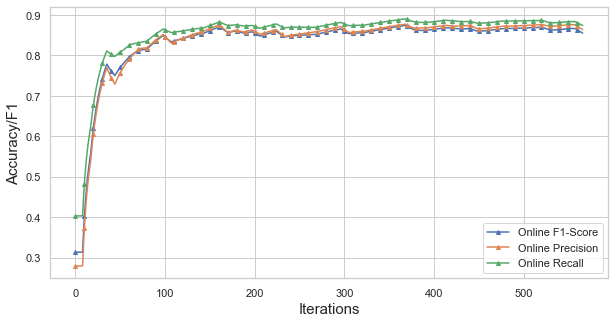

In [459]:
plt.figure(figsize=(10,5))
#plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,3][:-1]), label='Online Accuracy', marker='^', markersize=4,
#         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,4][:-1]), label='Online F1-Score', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,5][:-1]), label='Online Precision', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,6][:-1]), label='Online Recall', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.legend(loc='lower right')
#plt.yscale("log")
plt.xlabel("Iterations",fontsize=15)
plt.ylabel("Accuracy/F1",fontsize=15)

Text(0, 0.5, 'Loss')

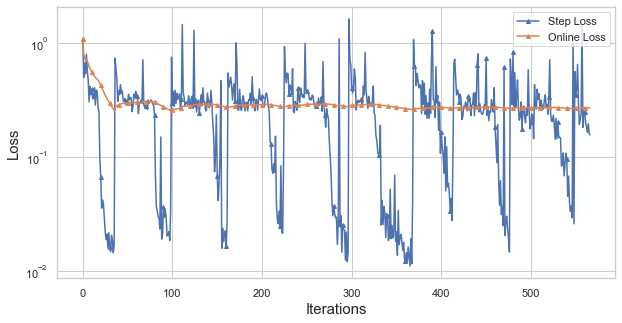

In [460]:
plt.figure(figsize=(10,5))
plt.plot(values_dmfw[:,0][:-1],values_dmfw[:,1][:-1], label='Step Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,1][:-1]), label='Online Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
plt.yscale("log")
plt.xlabel("Iterations",fontsize=15)
plt.ylabel("Loss",fontsize=15)

In [461]:
def prediction(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print("Accuracy : {} {}".format(100 * correct/total, "%"))

In [462]:
def ModelPrediction(model_to_test, date ,loader):
    correct = 0
    total = 0
    f1 = 0
    true_array = []
    pred_array = []
    model_to_test.eval()
    with torch.no_grad():
        for series, label in loader[date]:
            outputs = model_to_test(series)
            _, predicted = torch.max(outputs,1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            true_array.append(label.detach().numpy())
            pred_array.append(predicted.detach().numpy())
        truth_roll = np.hstack(true_array).flatten()
        pred_roll = np.hstack(pred_array)
        
        
        f1 = f1_score(truth_roll, pred_roll, average='weighted')
        precision = precision_score(truth_roll, pred_roll, average='weighted')
        recall = recall_score(truth_roll, pred_roll, average='weighted')
        conf_mat = confusion_matrix(truth_roll, pred_roll)
        accuracy = correct/total
        #print(classification_report(truth_roll, pred_roll))
    return accuracy, f1 , precision, recall, conf_mat, truth_roll, pred_roll

def get_real_dataset(dates, model_idx):
    real_index = [1,2,4,5]
    databydatereal = createDataByDate(resample_data_classes, "ACPower", dates)
    acpower = []
    for date in dates:
        trainy = rolling_window(databydatereal[date][f'Floor7Z{real_index[model_idx]}'], seq_len)
        #print(trainy.shape)
        acpower.append(trainy)
    acpower = np.asarray(acpower)
    #print(acpower.shape)
    shape = acpower.shape
    flatten = acpower.reshape(shape[0]*shape[1],seq_len)[::seq_len].flatten()
    return flatten[:-6]

In [407]:
date_acc, date_f1, date_prec, date_rec, conf_mat, true, pred = ModelPrediction(trainXMFW.best_models[model_idx], test_date[i], testloader[model_idx])

In [408]:
len(test_date)

237

In [475]:
test_acc = []
test_f1 = []
test_prec = []
test_rec = []
prediction = []
truth = []
model_idx = 3
real_index_zone = [1,2,4,5]
date_to_test = test_date[:50]
for i,date in enumerate(date_to_test):
    #print(f'-----{test_date[i]}-----')
    date_acc, date_f1, date_prec, date_rec, conf_mat, true, pred = ModelPrediction(trainXMFW.best_models[model_idx], test_date[i], testloader[model_idx])
    conf_mat = pd.DataFrame(conf_mat)
    test_acc.append(date_acc)
    test_f1.append(date_f1)
    test_prec.append(date_prec)
    test_rec.append(date_rec)
    #print(len(true))
    truth.append(true)
    prediction.append(pred)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Slaton/miniforge3/envs/tf_macos/lib/pyt

In [476]:
scorepd = pd.DataFrame({"Test Acc": test_acc, 
                        "Test F1": test_f1, 
                        "Test Precision":test_prec, 
                        "Test Recall":test_rec})

real_val = resample_data[f'Floor7Z{real_index_zone[model_idx]}'].loc[resample_data[f'Floor7Z{real_index_zone[model_idx]}'].apply(lambda x: x.date in date_to_test, axis=1)]
resultpd = pd.DataFrame({"Prediction": np.asarray(prediction).flatten(),
                         "Truth": np.asarray(truth).flatten(),
                        "RealValue":get_real_dataset(date_to_test,model_idx)})


/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_7813/565422866.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [477]:
pd.DataFrame.to_csv(scorepd,path_log+f'/score-zone{real_index_zone[model_idx]}.csv')
pd.DataFrame.to_csv(resultpd,path_log+f'/prediction-zone{real_index_zone[model_idx]}.csv')

In [478]:
pd.DataFrame.to_csv(pd.DataFrame(set_point), path_log+f'/setpointpower.csv')

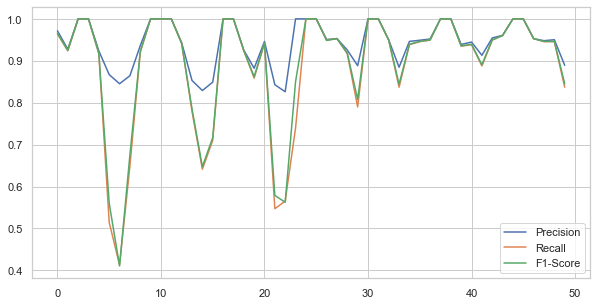

In [169]:
plt.figure(figsize=(10,5))
plt.plot(test_prec, label='Precision')
plt.plot(test_rec, label='Recall')
plt.plot(test_f1, label='F1-Score')
plt.legend()

In [209]:
real = resample_data_classes['Floor7Z4'].loc[resample_data_classes['Floor7Z4'].apply(lambda x: x.date in hehe, axis=1)]

In [210]:
realac = real['ACPower']

In [215]:
hehe.shape

(14388, 13)

In [174]:
truetrue = np.asarray(truth).flatten()
predpred = np.asarray(prediction).flatten()

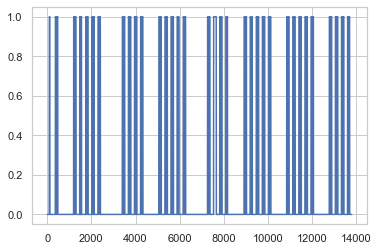

In [175]:
plt.plot(np.asarray(truth).flatten())

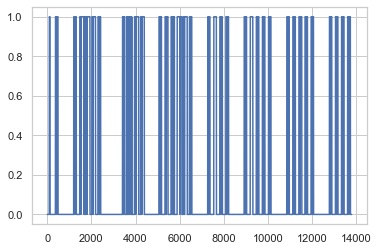

In [176]:
plt.plot(np.asarray(prediction).flatten())

8pm to 8am check data and validation
lunch time check